### Topic Modeling using BerTopic

- https://maartengr.github.io/BERTopic/algorithm/algorithm.html
- https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html

#### Reading the data from CSV

In [1]:
import pandas as pd
df=pd.read_csv("data/train.csv") #chanage your path here
df=df[:1000].copy()  #filtering the first 1000 rows- just for testing purposes - to be commented in main code
docs=df["text"].to_list()  #select your text column here - topic modeling will run on this column
print(df.shape)
df.head()

(1000, 2)


,text,label
0,Last session of the day http://twitpic.com/67ezh,1
1,Shanghai is also really exciting (precisely -...,2
2,"Recession hit Veronique Branquinho, she has to...",0
3,happy bday!,2
4,http://twitpic.com/4w75p - I like it!!,2


### Elbow method


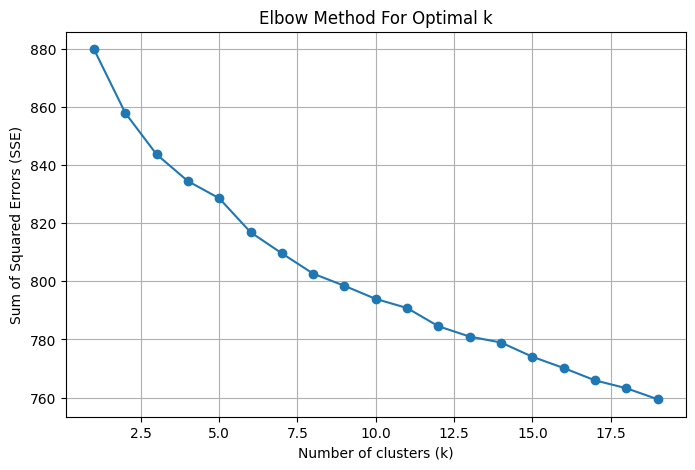

In [6]:
# Load pre-trained SBERT model
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(docs)

# Elbow method: find optimal number of clusters
sse = []  # Sum of squared errors
k_values = range(1, 20)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings)
    sse.append(kmeans.inertia_)  # inertia_ is the SSE

# Plot SSE vs number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

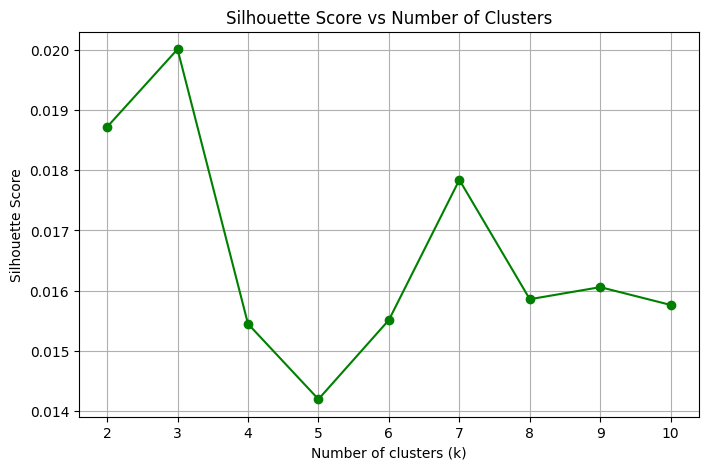

In [10]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(docs)

# Silhouette score for k in range
silhouette_scores = []
k_values = range(2, 11)  # Silhouette score is undefined for k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

#### Bertopic code
Refer to documentation for learning each component :
https://maartengr.github.io/BERTopic/algorithm/algorithm.html


In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer


# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

num_topics = 3
kmeans = KMeans(n_clusters=num_topics, random_state=0)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations


)

In [63]:
embeddings = embedding_model.encode(docs, show_progress_bar=True)
topics , probs=topic_model.fit_transform(docs)
df["Predicted_Topic"]=topics
df["Probablity"]=probs

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

#### Creating topic modeling results and saving in CSV

In [42]:
df_topic_info=pd.DataFrame(topic_model.get_topic_info())
df_topic_info.to_csv("topic_info.csv",index=False)
print(f"Total Topics :{df_topic_info.shape[0]}")
df_topic_info

Total Topics :10


,Topic,Count,Name,Representation,Representative_Docs
0,-1,506,-1_happy_love_morning_bye,"[happy, love, morning, bye, glad, hey, yay, da...","[http://twitpic.com/4ja8r - Tell me, how can y..."
1,0,117,0_twitter_tweet_tweets_twitterland,"[twitter, tweet, tweets, twitterland, tweetdec...",[ look who I found just for you ---> http://...
2,1,80,1_hollyoaks_cried_concert_watch,"[hollyoaks, cried, concert, watch, bgt, watche...",[Just listened to condre scr and got an invita...
3,2,67,2_morning_goodnight_night_asleep,"[morning, goodnight, night, asleep, sleep, wak...","[Good morning everyone, Good night, Rob. Slee..."
4,3,64,3_sunshine_sun_raining_monsoon,"[sunshine, sun, raining, monsoon, sunscreen, w...",[Got caught in the rain. Sand Monsoon all the ...
5,4,61,4_sick_nauseous_hungry_flu,"[sick, nauseous, hungry, flu, bread, breakfast...",[All of a sudden I`m craving broccoli and chee...
6,5,29,5_life_depressed_miserable_happy,"[life, depressed, miserable, happy, feeling, f...","[the best things in life are free x, Thank y..."
7,6,29,6_mothers_mother_mama_mom,"[mothers, mother, mama, mom, mum, mommy, moms,...","[Happy mothers day mom ?, Happy Mothers Day,..."
8,7,27,7_photos_zoo_photo_outfit,"[photos, zoo, photo, outfit, stuffed, tyrannos...","[ I could, but that would require today not to..."
9,8,20,8_thanks_welcome_following_chtx7e,"[thanks, welcome, following, chtx7e, tinyurl, ...",[ Thanks for the hint. http://tinyurl.com/cht...


In [53]:
df_document_info=pd.DataFrame(topic_model.get_document_info(docs))
df_document_info.to_csv("document_info.csv",index=False)
df_document_info.head(3)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Last session of the day http://twitpic.com/67ezh,-1,-1_happy_love_morning_bye,"[happy, love, morning, bye, glad, hey, yay, da...","[http://twitpic.com/4ja8r - Tell me, how can y...",happy - love - morning - bye - glad - hey - ya...,0.000000,False
1,Shanghai is also really exciting (precisely -...,0,0_twitter_tweet_tweets_twitterland,"[twitter, tweet, tweets, twitterland, tweetdec...",[ look who I found just for you ---> http://...,twitter - tweet - tweets - twitterland - tweet...,0.521174,False
2,"Recession hit Veronique Branquinho, she has to...",1,1_hollyoaks_cried_concert_watch,"[hollyoaks, cried, concert, watch, bgt, watche...",[Just listened to condre scr and got an invita...,hollyoaks - cried - concert - watch - bgt - wa...,0.579041,False


In [ ]:
topic_model.get_topic(2)

### Creating Visulization

In [56]:
topic_model.visualize_topics()

In [57]:
topic_model.visualize_heatmap()


In [55]:
topic_model.visualize_barchart()

In [64]:
# Train BERTopic
# topic_model = BERTopic().fit(docs, embeddings)

# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

In [66]:
topic_model.visualize_barchart()

In [67]:
topic_model.visualize_term_rank()

In [68]:
topic_model.visualize_hierarchy()

In [70]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00,  8.42it/s]
